AINHOA GALLEGO - LSTM 90 - 64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
#!pip install keras
from statsmodels.tsa.seasonal import seasonal_decompose
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#!pip install keras --user
#!pip install tensorflow --user
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
#!pip install tensorflow --user
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten

In [ ]:
df = pd.read_csv('ANA.MC2015.csv')

# Convertimos la columna Date en un objeto datetime
df['Date'] = pd.to_datetime(df['Date'])
# Agregamos columnas de año, mes y día
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday  # Monday: 0, Sunday: 6 aunque no existen datos de fin de semana, la bolsa está cerrado; asi que es 0-4 de lunes-viernes

# Calcular el rendimiento diario
df['Return'] = df['Close'].pct_change()
df['Return'].fillna(0, inplace=True)

In [ ]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return']
# eliminamos los datos nulos
df = df.dropna()

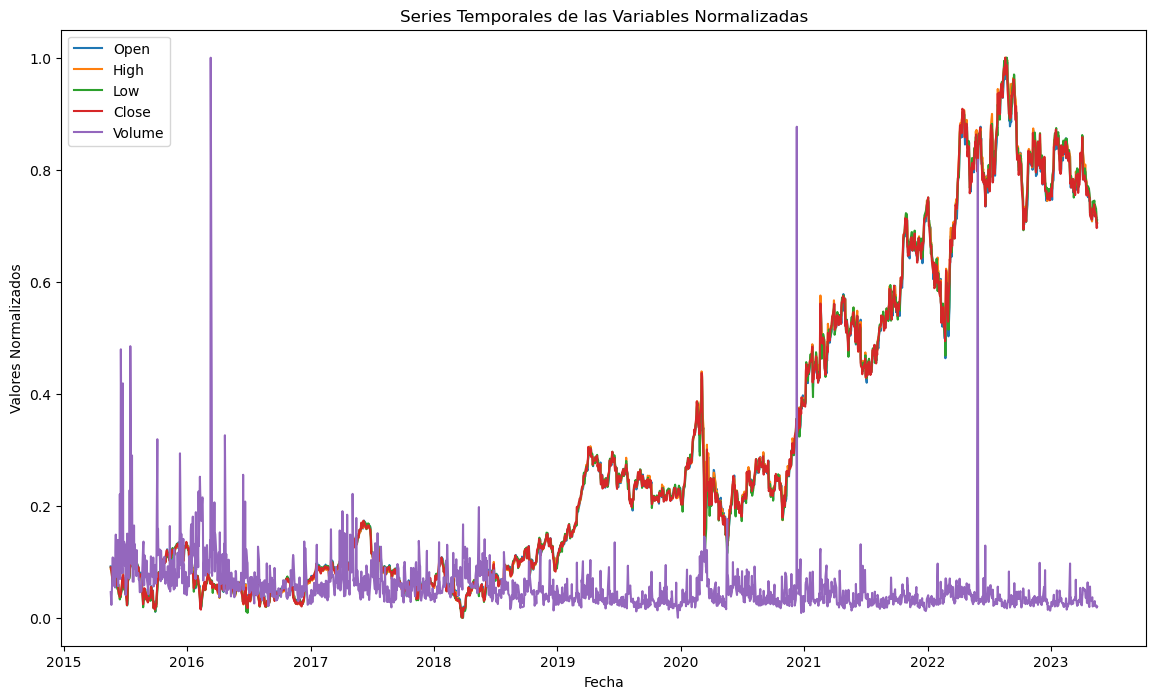

In [ ]:
# Definir las columnas que quieres representar
selected_cols = [col for col in num_cols if col != 'Return']

# Normalizar las columnas numéricas
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df[selected_cols]), columns=selected_cols)

# Agregar la columna 'Date' al dataframe normalizado
scaled_df['Date'] = df['Date']

# Graficar las series temporales de las variables normalizadas
plt.figure(figsize=(14,8))

for column in selected_cols:
    plt.plot(scaled_df['Date'], scaled_df[column], label=column)

plt.xlabel('Fecha')
plt.ylabel('Valores Normalizados')
plt.title('Series Temporales de las Variables Normalizadas')
plt.legend()
plt.show()

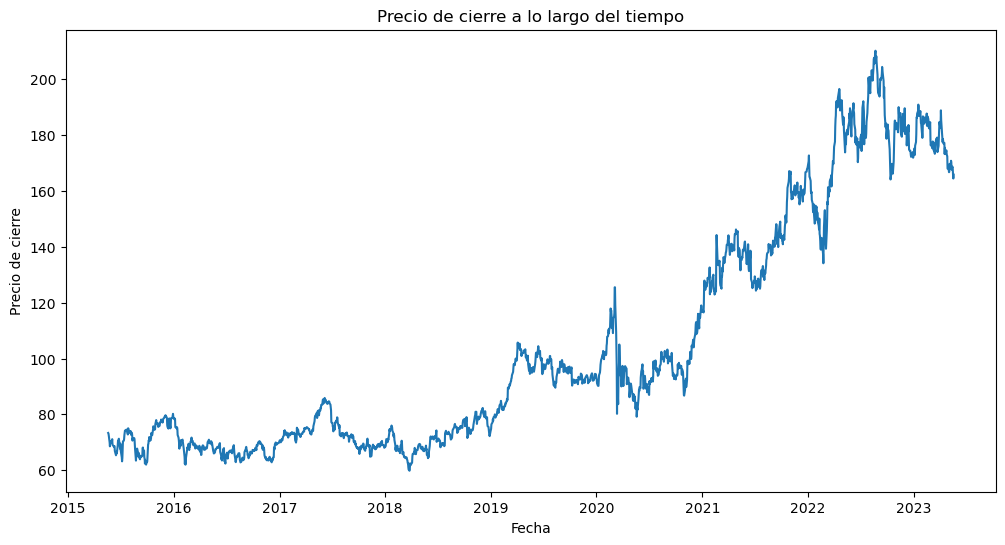

In [ ]:
#VAMOS A MOSTRAT ESTO
# Gráficas de las series temporales
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'])
plt.title('Precio de cierre a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()

## MODELO

In [ ]:
data = df['Close'].values.reshape(-1,1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
# Dividimos los datos en entrenamiento y prueba
train_size = int(len(scaled_data) * 0.6) #esto lo voya cambiar por 70/30 para evitar sobreajuste
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]
# Función para crear el dataset de entrenamiento
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Creamos el dataset de entrenamiento (train set)
look_back = 90 #aqui cambio la cantidad de días que quiero que mire hacia atras para entrenar el modelo #ESTO QUEREMOS 30, 60 Y 90 (Con sus errores etc)
X_train, y_train = create_dataset(train, look_back)

# Creamos el dataset de prueba (test set)
X_test, y_test = create_dataset(test, look_back)

In [ ]:
# Convertimos los datos a arreglos de numpy para la fomra en la que tienen que entrar en el modelo
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
## Modelo de RNN LSTM
# Definimos el modelo
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))# vamos a probar 16,32,64 para cada 30,60,90 (pueod crear un jupiter para cada prueba)
model.add(Dense(1)) #anadimos 1 nueroa de una Red neuronal para que de el output porque es a 1 dia vista
model.compile(loss='mean_squared_error', optimizer='adam') #intenta minima el MAPE

In [ ]:
from keras.callbacks import EarlyStopping
# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1)

# Entrenamos el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, callbacks=[es]) #batch 16 y epoch 50

# Hacemos las predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertimos las predicciones, es decir, que vuelven a mostrar su valor real. Es por eso que al principio hemos normalizado las variables de apertura y cierre separadamente. Pra no tener que desnormalizar todo ahora sino solo las de cierre.
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

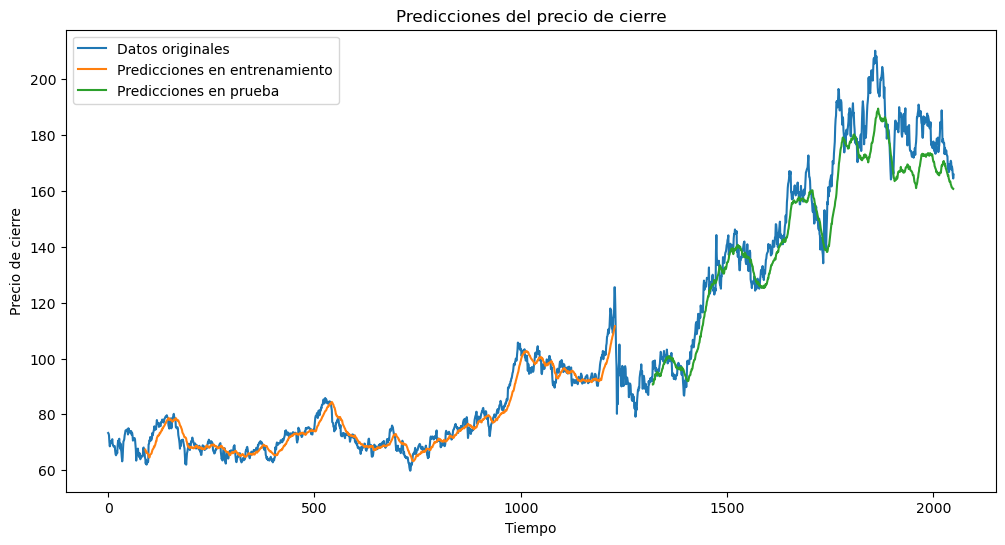

In [ ]:
# Graficamos los datos
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict
plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(scaled_data), label='Datos originales')
plt.plot(train_predict_plot, label='Predicciones en entrenamiento')
plt.plot(test_predict_plot, label='Predicciones en prueba')
plt.xlabel('Tiempo')
plt.ylabel('Precio de cierre')
plt.title('Predicciones del precio de cierre')
plt.legend()
plt.show()


In [ ]:
# Definir las funciones para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calcular las métricas para el conjunto de entrenamiento
rmse_train = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
mape_train = mean_absolute_percentage_error(y_train[0], train_predict[:,0])
mae_train = mean_absolute_error(y_train[0], train_predict[:,0])
r2_train = r2_score(y_train[0], train_predict[:,0])

# Calcular las métricas para el conjunto de prueba
rmse_test = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
mape_test = mean_absolute_percentage_error(y_test[0], test_predict[:,0])
mae_test = mean_absolute_error(y_test[0], test_predict[:,0])
r2_test = r2_score(y_test[0], test_predict[:,0])

# Crear un DataFrame para visualizar los resultados
results = pd.DataFrame({'Set': ['Entrenamiento', 'Prueba'],
                        'RMSE': [rmse_train, rmse_test],
                        'MAPE': [mape_train, mape_test],
                        'MAE': [mae_train, mae_test],
                        'R2': [r2_train, r2_test]})
print(results)


             Set       RMSE      MAPE       MAE        R2
0  Entrenamiento   3.249096  3.145326  2.477076  0.930036
1         Prueba  10.332805  4.915571  7.894665  0.892013


In [ ]:
#TODAVIA ESTO BO LO CORRO
# Convertir los arrays de NumPy a DataFrames de pandas
real_data_df = pd.DataFrame(np.concatenate((y_train, y_test)), columns=['Real_Data'])

# Extender 'train_predict' con NaNs para que coincida con la longitud de 'real_data'
train_predict_extended = np.concatenate((train_predict, [np.nan]*len(y_test)))
train_predict_df = pd.DataFrame(train_predict_extended, columns=['Train_Fit'])

# Extender 'test_predict' con NaNs al principio para que coincida con la longitud de 'real_data'
test_predict_extended = np.concatenate(([np.nan]*len(y_train), test_predict))
test_predict_df = pd.DataFrame(test_predict_extended, columns=['Test_Predictions'])

# Concatenar estos DataFrames a lo largo del eje de las columnas
result_df = pd.concat([real_data_df, train_predict_df, test_predict_df], axis=1)

# Guardar el DataFrame resultante en un archivo .csv
result_df.to_csv('predictions.csv', index=False)